## Decipher

### Loading Packages

In [1]:
from fastai.imports import *
from fastai.structured import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import date
from IPython.display import display
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 12, 8
from datetime import datetime
from fastai.custom_estimator_regressor import Estimator
from sklearn.model_selection import KFold

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

### Custom Functions

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
        
def rmse(x,y): 
    return 100*math.sqrt(((x-y)**2).mean())

### Loading Train and Test datasets

In [4]:
Path = './data/decipher/'

In [5]:
train = pd.read_csv(f'{Path}train.csv')

In [6]:
test = pd.read_csv(f'{Path}test.csv')

In [7]:
submission = pd.read_csv(f'{Path}sample.csv')

In [8]:
test['cc_cons'] = 0

In [9]:
train.shape, test.shape, submission.shape

((32820, 44), (14067, 44), (14067, 2))

In [10]:
submission.head()

,id,cc_cons
0,6975,7000
1,43223,7000
2,45502,7000
3,12368,7000
4,40415,7000


In [11]:
display_all(train.head())

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,cc_cons
0,23334,saving,M,63,305,7695.00,NaN,479.00,NaN,622.0,NaN,2.0,1.0,3.0,NaN,NaN,NaN,150000.0,NaN,NaN,NaN,NaN,NaN,118845.2,50000.0,NaN,51205.47,50259.0,3.0,1.0,50000.0,24740.22,114252.0,3.0,2.0,45000.0,20215.85,1279.37,7.0,3.0,470.0,NaN,0.00,435
1,20329,current,M,33,326,52702.00,988.72,29873.00,NaN,1087.0,2806.24,11.0,14.0,11.0,1.0,NaN,6.0,176000.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,159050.76,169812.0,20.0,9.0,70000.0,103102.85,174606.0,6.0,10.0,150000.0,122037.66,55390.00,8.0,19.0,27000.0,NaN,4963.33,1921
2,17679,current,M,44,264,10800.49,3215.52,21659.64,1607.0,1168.0,355.00,6.0,9.0,6.0,3.0,2.0,14.0,65000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51484.55,38942.0,16.0,4.0,11700.0,15283.00,23051.0,2.0,7.0,13800.0,46827.00,29297.91,6.0,19.0,20800.0,NaN,0.00,1970
3,16428,saving,M,44,233,20936.00,NaN,2094.00,NaN,11778.5,NaN,9.0,6.0,6.0,NaN,NaN,NaN,600000.0,NaN,NaN,NaN,NaN,NaN,132442.0,NaN,NaN,1981.07,2294.0,2.0,1.0,2000.0,19361.24,19529.0,1.0,1.0,19300.0,5426.55,7544.00,3.0,1.0,5300.0,NaN,1238.18,21579
4,18721,saving,F,35,324,1183.83,NaN,3656.29,NaN,945.0,NaN,2.0,7.0,9.0,NaN,NaN,NaN,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6462.00,10271.0,6.0,1.0,10000.0,7461.00,3194.0,2.0,3.0,3000.0,26178.05,53483.00,4.0,4.0,45000.0,NaN,0.00,1814


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32820 entries, 0 to 32819
Data columns (total 44 columns):
id                       32820 non-null int64
account_type             32820 non-null object
gender                   32820 non-null object
age                      32820 non-null int64
region_code              32820 non-null int64
cc_cons_apr              32820 non-null float64
dc_cons_apr              13768 non-null float64
cc_cons_may              32820 non-null float64
dc_cons_may              15481 non-null float64
cc_cons_jun              32820 non-null float64
dc_cons_jun              11523 non-null float64
cc_count_apr             30421 non-null float64
cc_count_may             31667 non-null float64
cc_count_jun             31230 non-null float64
dc_count_apr             13768 non-null float64
dc_count_may             15481 non-null float64
dc_count_jun             17323 non-null float64
card_lim                 32811 non-null float64
personal_loan_active     2742 non-n

In [13]:
train.describe()

,id,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
count,32820.000000,32820.000000,32820.000000,32820.000000,13768.000000,3.282000e+04,15481.000000,32820.000000,11523.000000,30421.000000,31667.000000,31230.000000,13768.000000,15481.000000,17323.000000,32811.000000,2742.0,846.0,2883.0,1625.0,1.426000e+03,2.338000e+03,1.332000e+03,406.000000,3.093000e+04,2.951800e+04,31062.000000,31062.000000,2.951800e+04,3.051900e+04,2.941500e+04,30749.000000,30749.000000,2.941500e+04,3.062500e+04,3.127700e+04,31292.000000,31292.000000,3.127700e+04,3.282000e+04,32820.000000
mean,23450.929616,35.951676,554.854327,16661.907189,5727.615837,1.441190e+04,5635.506904,9031.179889,4666.713420,9.162191,9.540184,12.298687,5.256900,6.267618,7.897016,121553.749657,1.0,1.0,1.0,1.0,8.115118e+05,1.765459e+05,3.975786e+04,4972.642169,7.002974e+04,7.541190e+04,14.887290,3.791771,4.647113e+04,6.709618e+04,7.959347e+04,4.087352,13.934795,4.969688e+04,7.759673e+04,7.583531e+04,5.767736,16.001438,4.474355e+04,9.567620e+03,6824.631840
std,13495.676061,8.529949,188.220317,25138.435416,11544.058014,2.363688e+04,14052.343253,15720.847307,10265.189742,10.790714,9.648387,11.714253,6.147011,7.380032,9.197672,123019.826520,0.0,0.0,0.0,0.0,4.418812e+06,4.403071e+05,8.430780e+04,6107.212042,1.641944e+05,1.777199e+05,11.589652,3.482266,1.181413e+05,1.855331e+05,2.026879e+05,3.847766,11.455178,1.287256e+05,3.140103e+05,3.062791e+05,4.704716,13.370195,1.215379e+05,2.616736e+05,12459.140593
min,0.000000,22.000000,123.000000,233.970000,10.010000,1.030000e+02,20.000000,51.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,1.0,1.0,2.000000e-02,3.000000e+00,0.000000e+00,-12179.000000,4.010000e+00,3.432000e+01,0.000000,0.000000,1.800000e-01,1.500000e-01,1.061000e+01,0.000000,0.000000,1.500000e-01,5.230000e+00,1.188000e+01,0.000000,0.000000,6.000000e-02,0.000000e+00,0.000000
25%,11824.750000,31.000000,425.000000,3712.000000,849.000000,2.983298e+03,796.000000,1637.875000,743.000000,3.000000,3.000000,4.000000,1.000000,2.000000,2.000000,45000.000000,1.0,1.0,1.0,1.0,4.885100e+03,3.500000e+04,6.971250e+03,977.000000,2.229260e+04,2.531025e+04,6.000000,2.000000,1.800000e+04,2.010401e+04,2.467500e+04,2.000000,6.000000,1.817300e+04,2.509642e+04,2.306400e+04,3.000000,6.000000,1.600000e+04,0.000000e+00,1285.000000
50%,23478.500000,34.000000,575.000000,8912.790000,2282.160000,7.332298e+03,2129.000000,4147.487500,1832.000000,7.000000,7.000000,9.000000,3.000000,4.000000,5.000000,75000.000000,1.0,1.0,1.0,1.0,3.289308e+04,8.500000e+04,2.500000e+04,5427.500000,4.114024e+04,4.394596e+04,12.000000,3.000000,2.813100e+04,3.836849e+04,4.538700e+04,3.000000,11.000000,3.000000e+04,4.593499e+04,4.295500e+04,5.000000,13.000000,2.687600e+04,1.510650e+02,3141.000000
75%,35096.250000,39.000000,683.000000,19932.060000,6074.600000,1.684785e+04,5640.000000,10126.250000,4607.500000,12.000000,13.000000,17.000000,7.000000,8.000000,10.000000,145000.000000,1.0,1.0,1.0,1.0,1.748331e+05,1.763457e+05,5.000000e+04,6885.000000,7.541069e+04,7.975369e+04,20.000000,5.000000,4.800000e+04,7.373561e+04,8.917050e+04,5.000000,19.000000,5.000000e+04,8.413612e+04,8.072400e+04,7.000000,22.000000,4.701000e+04,4.176868e+03,7349.250000
max,46886.000000,224.000000,977.000000,804712.580000,366223.160000,1.117246e+06,911223.490000,382914.100000,301991.940000,1012.000000,601.000000,653.000000,82.000000,97.000000,104.000000,1000000.000000,1.0,1.0,1.0,1.0,8.445222e+07,

In [14]:
numerical = train._get_numeric_data().columns.tolist()
categorical = ['account_type', 'gender']

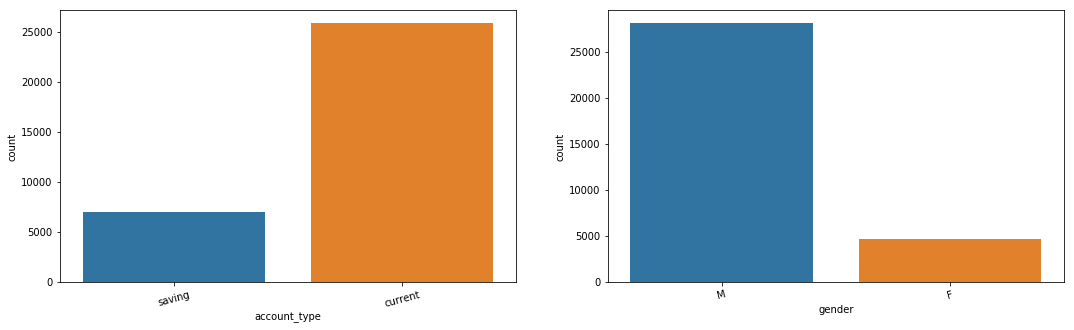

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(15)

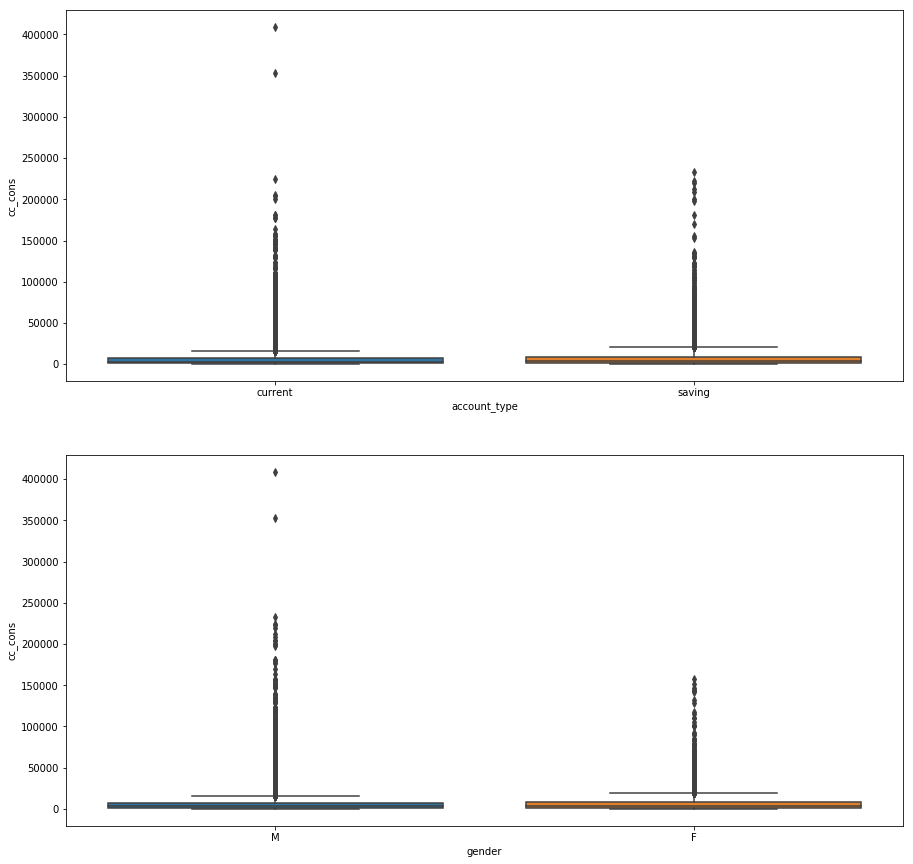

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
for var, subplot in zip(categorical, ax.flatten()):
    sorted_vals = train.groupby([var])['cc_cons'].mean().sort_values()
    sns.boxplot(x=var, y='cc_cons', data=train, ax=subplot, order=list(sorted_vals.index))

### Check for missing values

In [17]:
for df in (train, test):
    missing_stats = df.isnull().mean()
    print(round(100 * missing_stats[missing_stats != 0],2))
#     print(missing_stats[missing_stats != 0], '\n')

dc_cons_apr              58.05
dc_cons_may              52.83
dc_cons_jun              64.89
cc_count_apr              7.31
cc_count_may              3.51
cc_count_jun              4.84
dc_count_apr             58.05
dc_count_may             52.83
dc_count_jun             47.22
card_lim                  0.03
personal_loan_active     91.65
vehicle_loan_active      97.42
personal_loan_closed     91.22
vehicle_loan_closed      95.05
investment_1             95.66
investment_2             92.88
investment_3             95.94
investment_4             98.76
debit_amount_apr          5.76
credit_amount_apr        10.06
debit_count_apr           5.36
credit_count_apr          5.36
max_credit_amount_apr    10.06
debit_amount_may          7.01
credit_amount_may        10.37
credit_count_may          6.31
debit_count_may           6.31
max_credit_amount_may    10.37
debit_amount_jun          6.69
credit_amount_jun         4.70
credit_count_jun          4.66
debit_count_jun           4.66
max_cred

### Fix missing values

In [18]:
# train = train[train.columns[train.isnull().mean() < 0.9]]
# test = test[test.columns[test.isnull().mean() < 0.9]]

In [19]:
train.shape, test.shape

((32820, 44), (14067, 44))

### Feature Engineering

In [20]:
display_all(train.head())

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,cc_cons
0,23334,saving,M,63,305,7695.00,NaN,479.00,NaN,622.0,NaN,2.0,1.0,3.0,NaN,NaN,NaN,150000.0,NaN,NaN,NaN,NaN,NaN,118845.2,50000.0,NaN,51205.47,50259.0,3.0,1.0,50000.0,24740.22,114252.0,3.0,2.0,45000.0,20215.85,1279.37,7.0,3.0,470.0,NaN,0.00,435
1,20329,current,M,33,326,52702.00,988.72,29873.00,NaN,1087.0,2806.24,11.0,14.0,11.0,1.0,NaN,6.0,176000.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,159050.76,169812.0,20.0,9.0,70000.0,103102.85,174606.0,6.0,10.0,150000.0,122037.66,55390.00,8.0,19.0,27000.0,NaN,4963.33,1921
2,17679,current,M,44,264,10800.49,3215.52,21659.64,1607.0,1168.0,355.00,6.0,9.0,6.0,3.0,2.0,14.0,65000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51484.55,38942.0,16.0,4.0,11700.0,15283.00,23051.0,2.0,7.0,13800.0,46827.00,29297.91,6.0,19.0,20800.0,NaN,0.00,1970
3,16428,saving,M,44,233,20936.00,NaN,2094.00,NaN,11778.5,NaN,9.0,6.0,6.0,NaN,NaN,NaN,600000.0,NaN,NaN,NaN,NaN,NaN,132442.0,NaN,NaN,1981.07,2294.0,2.0,1.0,2000.0,19361.24,19529.0,1.0,1.0,19300.0,5426.55,7544.00,3.0,1.0,5300.0,NaN,1238.18,21579
4,18721,saving,F,35,324,1183.83,NaN,3656.29,NaN,945.0,NaN,2.0,7.0,9.0,NaN,NaN,NaN,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6462.00,10271.0,6.0,1.0,10000.0,7461.00,3194.0,2.0,3.0,3000.0,26178.05,53483.00,4.0,4.0,45000.0,NaN,0.00,1814


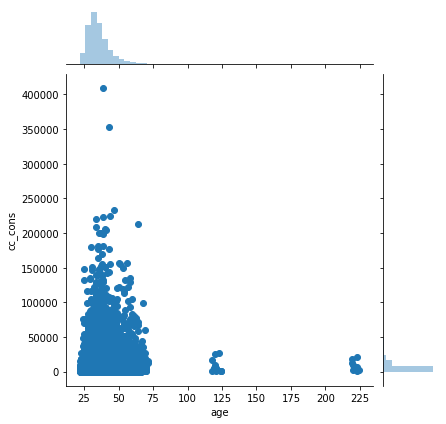

In [21]:
sns.jointplot(x=train['age'], y=train['cc_cons'])

In [22]:
train[train['age'] < 75].groupby(['gender'])['age'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,4712.0,34.227929,7.076187,22.0,29.0,33.0,37.0,70.0
M,28083.0,36.122352,7.620676,22.0,31.0,35.0,40.0,71.0


In [23]:
for df in (train, test):
    df['card_lim'] = df['card_lim'].fillna(df['card_lim'])

In [24]:
for df in (train, test):
    df['age'] = np.where(((df['age'] > 75) & (df['gender'] == 'M'))
                         , 36
                         , np.where(((df['age'] > 75) & (df['gender'] == 'F'))
                                   ,34
                                   ,df['age']
                                  )
                        )
    
    df['high_cc_con_june'] = np.where((df['cc_cons_jun'] > df['cc_cons_may']) 
                                      & (df['cc_cons_jun'] <= df['cc_cons_apr'])
                                      , 1, 0
                                     )
    
    df['cc_cons_avg'] = df[['cc_cons_apr', 'cc_cons_may', 'cc_cons_jun']].mean(axis=1)
    
    df['cc_lim_con_ratio_apr'] = np.where(df['card_lim'] > 0, df['cc_cons_apr']/df['card_lim'], 0)
    df['cc_lim_con_ratio_may'] = np.where(df['card_lim'] > 0, df['cc_cons_may']/df['card_lim'], 0)
    df['cc_lim_con_ratio_jun'] = np.where(df['card_lim'] > 0, df['cc_cons_jun']/df['card_lim'], 0)
    df['cc_cons_avg_lim_ratio'] = np.where(df['card_lim'] > 0, df['cc_cons_avg']/df['card_lim'], 0)

    
    df['cc_cnt_total'] = df[['cc_count_apr', 'cc_count_may', 'cc_count_jun']].sum(axis=1)
    df['cc_cnt_avg'] = df[['cc_count_apr', 'cc_count_may', 'cc_count_jun']].mean(axis=1)
    
    df['credit_amt_avg'] = df[['credit_amount_apr', 'credit_amount_may', 'credit_amount_jun']].mean(axis=1)

    df['apr_balance'] = df['credit_amount_apr'] - df['debit_amount_apr']
    df['may_balance'] = df['credit_amount_may'] - df['debit_amount_may']
    df['jun_balance'] = df['credit_amount_jun'] - df['debit_amount_jun']

In [25]:
train_cats(train)
apply_cats(test, train)

In [26]:
train = train[train['cc_cons'] > 0] 
train['cc_cons'] = np.log(train['cc_cons'])

In [27]:
df_train, y, nas = proc_df(train, 'cc_cons', skip_flds=['id'])
df_test, _, nas = proc_df(test, 'cc_cons', skip_flds=['id'])

In [28]:
print(df_train.shape)
df_train.head()

(32816, 91)


,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,high_cc_con_june,cc_cons_avg,cc_lim_con_ratio_apr,cc_lim_con_ratio_may,cc_lim_con_ratio_jun,cc_cons_avg_lim_ratio,cc_cnt_total,cc_cnt_avg,credit_amt_avg,apr_balance,may_balance,jun_balance,dc_cons_apr_na,dc_cons_may_na,dc_cons_jun_na,cc_count_apr_na,cc_count_may_na,cc_count_jun_na,dc_count_apr_na,dc_count_may_na,dc_count_jun_na,card_lim_na,personal_loan_active_na,vehicle_loan_active_na,personal_loan_closed_na,vehicle_loan_closed_na,investment_1_na,investment_2_na,investment_3_na,investment_4_na,debit_amount_apr_na,credit_amount_apr_na,debit_count_apr_na,credit_count_apr_na,max_credit_amount_apr_na,debit_amount_may_na,credit_amount_may_na,credit_count_may_na,debit_count_may_na,max_credit_amount_may_na,debit_amount_jun_na,credit_amount_jun_na,credit_count_jun_na,debit_count_jun_na,max_credit_amount_jun_na,credit_amt_avg_na,apr_balance_na,may_balance_na,jun_balance_na
0,2,2,63,305,7695.00,5728.344057,479.00,5635.328688,622.0,4667.04049,2.0,1.0,3.0,5.256375,6.265797,7.894688,150000.0,1.0,1.0,1.0,1.0,811511.814383,118845.200000,50000.000000,4972.642169,51205.47,50259.0,3.0,1.0,50000.0,24740.22,114252.0,3.0,2.0,45000.0,20215.85,1279.37,7.0,3.0,470.0,0,0.00,1,2932.000000,0.051300,0.003193,0.004147,0.019547,6.0,2.0,55263.456667,-946.47,89511.78,-18936.48,True,True,True,False,False,False,True,True,True,False,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,2,33,326,52702.00,988.720000,29873.00,5635.328688,1087.0,2806.24000,11.0,14.0,11.0,1.000000,6.265797,6.000000,176000.0,1.0,1.0,1.0,1.0,811511.814383,176619.333693,39757.860147,4972.642169,159050.76,169812.0,20.0,9.0,70000.0,103102.85,174606.0,6.0,10.0,150000.0,122037.66,55390.00,8.0,19.0,27000.0,0,4963.33,0,27887.333333,0.299443,0.169733,0.006176,0.158451,36.0,12.0,133269.333333,10761.24,71503.15,-66647.66,False,True,False,False,False,False,False,True,False,False,True,True,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1,2,44,264,10800.49,3215.520000,21659.64,1607.000000,1168.0,355.00000,6.0,9.0,6.0,3.000000,2.000000,14.000000,65000.0,1.0,1.0,1.0,1.0,811511.814383,176619.333693,39757.860147,4972.642169,51484.55,38942.0,16.0,4.0,11700.0,15283.00,23051.0,2.0,7.0,13800.0,46827.00,29297.91,6.0,19.0,20800.0,0,0.00,0,11209.376667,0.166161,0.333225,0.017969,0.172452,21.0,7.0,30430.303333,-12542.55,7768.00,-17529.09,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2,2,44,233,20936.00,5728.344057,2094.00,5635.328688,11778.5,4667.04049,9.0,6.0,6.0,5.256375,6.265797,7.894688,600000.0,1.0,1.0,1.0,1.0,811511.814383,132442.000000,39757.860147,4972.642169,1981.07,2294.0,2.0,1.0,2000.0,19361.24,19529.0,1.0,1.0,19300.0,5426.55,7544.00,3.0,1.0,5300.0,0,1238.18,1,11602.833333,0.034893,0.003490,0.019631,0.019338,21.0,7.0,9789.000000,312.93,167.76,2117.45,True,True,True,False,False,False,True,True,True,False,True,True,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2,1,35,324,1183.83,5728.344057,3656.29,5635.328688,945.0,4667.04

In [29]:
df_train.describe()

,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,high_cc_con_june,cc_cons_avg,cc_lim_con_ratio_apr,cc_lim_con_ratio_may,cc_lim_con_ratio_jun,cc_cons_avg_lim_ratio,cc_cnt_total,cc_cnt_avg,credit_amt_avg,apr_balance,may_balance,jun_balance
count,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,3.281600e+04,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.0,32816.0,32816.0,32816.0,3.281600e+04,3.281600e+04,3.281600e+04,32816.000000,3.281600e+04,3.281600e+04,32816.000000,32816.000000,3.281600e+04,3.281600e+04,3.281600e+04,32816.000000,32816.000000,3.281600e+04,3.281600e+04,3.281600e+04,32816.000000,32816.000000,3.281600e+04,32816.000000,3.281600e+04,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,32816.000000,3.281600e+04,3.281600e+04,3.281600e+04,3.281600e+04
mean,1.213128,1.856351,35.850713,554.840992,16663.226912,5728.344057,1.441298e+04,5635.328688,9030.459099,4667.040490,9.162798,9.541105,12.299388,5.256375,6.265797,7.894688,121553.756211,1.0,1.0,1.0,1.0,8.115118e+05,1.766193e+05,3.975786e+04,4972.642169,7.003637e+04,7.541672e+04,14.886953,3.791970,4.647402e+04,6.710239e+04,7.959961e+04,4.087461,13.934168,4.970044e+04,7.760419e+04,7.584352e+04,5.767866,16.000831,4.474841e+04,0.018558,9.568677e+03,0.214560,13368.887774,1.042883,1.338531,2.322063,1.567826,29.402944,10.132766,7.518828e+04,2.565246e+03,1.073702e+04,-2.572499e+02
std,0.409523,0.350739,7.570949,188.220478,25139.609996,7477.157703,2.363804e+04,9651.469026,15720.665342,6082.625784,10.389296,9.477619,11.427400,3.980703,5.066850,6.680921,122998.480495,0.0,0.0,0.0,0.0,9.208242e+05,1.174992e+05,1.697933e+04,678.475713,1.594051e+05,1.685521e+05,11.274025,3.387741,1.120470e+05,1.789210e+05,1.918963e+05,3.724498,11.087565,1.218720e+05,3.033456e+05,2.990098e+05,4.594013,13.055315,1.186528e+05,0.134960,2.616896e+05,0.410523,16780.002042,93.384820,153.809081,366.936521,202.080775,27.634011,9.220832,1.839032e+05,6.614621e+04,9.733694e+04,7.832642e+04
min,1.000000,1.000000,22.000000,123.000000,233.970000,10.010000,1.030000e+02,20.000000,51.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,1.0,1.0,2.000000e-02,3.000000e+00,0.000000e+00,-12179.000000,4.010000e+00,3.432000e+01,0.000000,0.000000,1.800000e-01,1.500000e-01,1.061000e+01,0.000000,0.000000,1.500000e-01,5.230000e+00,1.188000e+01,0.000000,0.000000,6.000000e-02,0.000000,0.000000e+00,0.000000,254.333333,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.061000e+01,-3.101086e+06,-5.693110e+06,-4.871634e+06
25%,1.000000,2.000000,31.000000,425.000000,3712.517500,3295.977500,2.984688e+03,2367.750000,1637.875000,3953.750000,3.000000,3.000000,5.000000,4.000000,4.000000,4.000000,45000.000000,1.0,1.0,1.0,1.0,8.115118e+05,1.766193e+05,3.975786e+04,4972.642169,2.334843e+04,2.728763e+04,7.000000,2.000000,1.920000e+04,2.130348e+04,2.654600e+04,2.000000,6.000000,1.989725e+04,2.636169e+04,2.405619e+04,3.000000,7.000000,1.668675e+04,0.000000,0.000000e+00,0.000000,4243.096667,0.045500,0.035863,0.019253,0.050971,12.000000,4.333333,3.003916e+04,-5.771545e+03,-2.685350e+03,-1.030029e+04
50%,1.000000,2.000000,34.000000,575.000000,8914.320000,5728.344057,7.333600e+03,5635.328688,4147.487500,4667.040490,7.000000,7.000000,10.000000,5.256375,6.265797,7.894688,75000.000000,1.0,1.0,1.0,1.0,8.

## LightGBM Model

In [30]:
params={
          'bagging_freq': 5
        , 'boosting_type': 'gbdt'
        , 'colsample_bytree': 0.4000000000000001
        , 'learning_rate': 0.01
        , 'min_child_weight': 300.0
        , 'n_estimators': 15000
        , 'n_jobs': -1
        , 'num_leaves': 64
        , 'subsample': 1.0
       }

In [31]:
mod=Estimator(model=LGBMRegressor(**params)
              ,n_jobs=-1
              ,validation_scheme='KFold'
              ,random_state=100
              ,n_splits=5
              ,early_stopping_rounds=200
              ,shuffle=True
             )

In [32]:
%%time
oof=mod.fit_transform(df_train.values,y)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 1.19273	valid_0's l2: 1.42261	valid_1's rmse: 1.18996	valid_1's l2: 1.416
[200]	valid_0's rmse: 1.16838	valid_0's l2: 1.36511	valid_1's rmse: 1.14724	valid_1's l2: 1.31616
[300]	valid_0's rmse: 1.16062	valid_0's l2: 1.34704	valid_1's rmse: 1.12422	valid_1's l2: 1.26387
[400]	valid_0's rmse: 1.15796	valid_0's l2: 1.34087	valid_1's rmse: 1.10653	valid_1's l2: 1.2244
[500]	valid_0's rmse: 1.15664	valid_0's l2: 1.33782	valid_1's rmse: 1.09075	valid_1's l2: 1.18973
[600]	valid_0's rmse: 1.15638	valid_0's l2: 1.33721	valid_1's rmse: 1.0764	valid_1's l2: 1.15863
[700]	valid_0's rmse: 1.15668	valid_0's l2: 1.33791	valid_1's rmse: 1.06294	valid_1's l2: 1.12983
Early stopping, best iteration is:
[593]	valid_0's rmse: 1.15626	valid_0's l2: 1.33695	valid_1's rmse: 1.07738	valid_1's l2: 1.16075
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 1.20365	valid_0's l2: 1.44876	valid_1

In [33]:
mod.cv_scores, mod.avg_cv_score,np.std(mod.cv_scores)

([115.62644265836055,
  116.41193173721697,
  117.3214495348238,
  117.11172553985791,
  116.09685825307487],
 116.51368154466681,
 0.6295130288103651)

In [34]:
Feature_Imp_1 = pd.DataFrame({'Features' : df_train.columns, 'Score' : mod.feature_importances()})
Feature_Imp_1.sort_values('Score', ascending=False).head(10)

,Features,Score
8,cc_cons_jun,0.043823
46,cc_lim_con_ratio_jun,0.037555
43,cc_cons_avg,0.037021
3,region_code,0.036366
16,card_lim,0.035059
6,cc_cons_may,0.033713
39,max_credit_amount_jun,0.031537
4,cc_cons_apr,0.030089
45,cc_lim_con_ratio_may,0.029429
53,jun_balance,0.028277


In [35]:
mod2=Estimator(model=LGBMRegressor(**params)
               ,n_jobs=-1
               ,validation_scheme='KFold'
               ,random_state=200
               ,n_splits=5
               ,early_stopping_rounds=200
               ,shuffle=True
              )

In [36]:
%%time
oof2=mod2.fit_transform(df_train.values,y)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 1.19691	valid_0's l2: 1.4326	valid_1's rmse: 1.18909	valid_1's l2: 1.41393
[200]	valid_0's rmse: 1.17034	valid_0's l2: 1.3697	valid_1's rmse: 1.14676	valid_1's l2: 1.31506
[300]	valid_0's rmse: 1.16188	valid_0's l2: 1.34997	valid_1's rmse: 1.12372	valid_1's l2: 1.26275
[400]	valid_0's rmse: 1.15801	valid_0's l2: 1.34098	valid_1's rmse: 1.10612	valid_1's l2: 1.22351
[500]	valid_0's rmse: 1.15581	valid_0's l2: 1.3359	valid_1's rmse: 1.09045	valid_1's l2: 1.18908
[600]	valid_0's rmse: 1.15448	valid_0's l2: 1.33282	valid_1's rmse: 1.07605	valid_1's l2: 1.15788
[700]	valid_0's rmse: 1.15392	valid_0's l2: 1.33152	valid_1's rmse: 1.06252	valid_1's l2: 1.12895
[800]	valid_0's rmse: 1.15403	valid_0's l2: 1.33179	valid_1's rmse: 1.04962	valid_1's l2: 1.10171
[900]	valid_0's rmse: 1.15424	valid_0's l2: 1.33227	valid_1's rmse: 1.0374	valid_1's l2: 1.0762
Early stopping, best iteration is:
[740]	valid_0's rmse: 1.1

In [37]:
mod2.cv_scores, mod2.avg_cv_score,np.std(mod2.cv_scores)

([115.38172630235854,
  117.94436240942035,
  116.70378266435276,
  116.30427567721082,
  115.72592282081706],
 116.41201397483192,
 0.8918567142330273)

In [38]:
Feature_Imp_2 = pd.DataFrame({'Features' : df_train.columns, 'Score' : mod2.feature_importances()})
Feature_Imp_2.sort_values('Score', ascending=False).head(10)

,Features,Score
8,cc_cons_jun,0.043896
46,cc_lim_con_ratio_jun,0.037672
3,region_code,0.036186
43,cc_cons_avg,0.035714
16,card_lim,0.034269
6,cc_cons_may,0.033050
39,max_credit_amount_jun,0.030708
4,cc_cons_apr,0.029905
45,cc_lim_con_ratio_may,0.029524
53,jun_balance,0.028209


## Catboost Model

In [39]:
cat=CatBoostRegressor(eval_metric='RMSE'
                      ,n_estimators=15000
                      ,od_type='Iter'
                      ,od_wait=400
                      ,colsample_bylevel=0.4
                      ,max_depth=6
                      ,learning_rate=0.02
                      ,verbose = 1000
                     )

In [40]:
catmod=Estimator(model=cat
                 ,early_stopping_rounds=200
                 ,random_state=100
                 ,n_jobs=-1
                 ,shuffle=True
                 ,validation_scheme='KFold'
                 ,n_splits=5
                 ,categorical_features_indices=[0, 1, 3] 
                )

In [41]:
%%time
catoof=catmod.fit_transform(df_train.values,y)

0:	learn: 7.9704159	total: 95.4ms	remaining: 23m 51s
1000:	learn: 1.1439662	total: 40.7s	remaining: 9m 29s
2000:	learn: 1.1247813	total: 1m 25s	remaining: 9m 15s
3000:	learn: 1.1092760	total: 2m 11s	remaining: 8m 44s
4000:	learn: 1.0952082	total: 3m	remaining: 8m 15s
5000:	learn: 1.0829947	total: 3m 42s	remaining: 7m 24s
6000:	learn: 1.0721071	total: 4m 21s	remaining: 6m 32s
7000:	learn: 1.0631820	total: 5m	remaining: 5m 43s
8000:	learn: 1.0557175	total: 5m 42s	remaining: 4m 59s
9000:	learn: 1.0486333	total: 6m 19s	remaining: 4m 12s
10000:	learn: 1.0423463	total: 6m 57s	remaining: 3m 28s
11000:	learn: 1.0363961	total: 7m 35s	remaining: 2m 45s
12000:	learn: 1.0313385	total: 8m 13s	remaining: 2m 3s
13000:	learn: 1.0263446	total: 8m 50s	remaining: 1m 21s
14000:	learn: 1.0221130	total: 9m 27s	remaining: 40.5s
14999:	learn: 1.0179122	total: 10m 5s	remaining: 0us
116.55331906004835
0:	learn: 7.9651921	total: 34.6ms	remaining: 8m 39s
1000:	learn: 1.1362912	total: 38.2s	remaining: 8m 54s
2000:

In [42]:
catmod.cv_scores, catmod.avg_cv_score,np.std(catmod.cv_scores)

([116.55331906004835,
  117.82764333475177,
  117.89367213820894,
  117.55251522962,
  117.44468597331199],
 117.45436714718821,
 0.4804036664907475)

In [43]:
catmod2=Estimator(model=cat
                 ,early_stopping_rounds=200
                 ,random_state=200
                 ,n_jobs=-1
                 ,shuffle=True
                 ,validation_scheme='KFold'
                 ,n_splits=5
                 ,categorical_features_indices=[0, 1, 3] 
                )

In [44]:
%%time
catoof2=catmod2.fit_transform(df_train.values,y)

0:	learn: 7.9699374	total: 39.8ms	remaining: 9m 57s
1000:	learn: 1.1426768	total: 38.9s	remaining: 9m 4s
2000:	learn: 1.1228617	total: 1m 18s	remaining: 8m 28s
3000:	learn: 1.1089530	total: 1m 56s	remaining: 7m 47s
4000:	learn: 1.0969750	total: 2m 35s	remaining: 7m 6s
5000:	learn: 1.0855082	total: 3m 13s	remaining: 6m 27s
6000:	learn: 1.0757448	total: 3m 52s	remaining: 5m 48s
7000:	learn: 1.0673010	total: 4m 31s	remaining: 5m 10s
8000:	learn: 1.0597443	total: 5m 9s	remaining: 4m 31s
9000:	learn: 1.0527406	total: 5m 48s	remaining: 3m 52s
10000:	learn: 1.0464455	total: 6m 27s	remaining: 3m 13s
11000:	learn: 1.0406047	total: 7m 5s	remaining: 2m 34s
12000:	learn: 1.0352316	total: 7m 44s	remaining: 1m 56s
13000:	learn: 1.0308979	total: 8m 22s	remaining: 1m 17s
14000:	learn: 1.0266134	total: 9m 1s	remaining: 38.6s
14999:	learn: 1.0222159	total: 9m 36s	remaining: 0us
116.56574521175433
0:	learn: 7.9724285	total: 34.3ms	remaining: 8m 34s
1000:	learn: 1.1430480	total: 33.2s	remaining: 7m 44s
20

In [45]:
catmod2.cv_scores, catmod2.avg_cv_score,np.std(catmod2.cv_scores)

([116.56574521175433,
  118.39754992552696,
  117.6303013365455,
  116.72654419041628,
  116.21836310638147],
 117.1077007541249,
 0.7958316205543835)

In [48]:
preds1=mod.predict(df_test.values)
preds2=mod2.predict(df_test.values)
preds3=catmod.predict(df_test.values)
preds4=catmod2.predict(df_test.values)

In [49]:
submission['preds1'] = np.exp(preds1)
submission['preds2'] = np.exp(preds2)
submission['preds3'] = np.exp(preds3)
submission['preds4'] = np.exp(preds4)
submission['cc_cons'] = round(submission[['preds1', 'preds2', 'preds3', 'preds4']].mean(axis=1))
submission.head()

,id,cc_cons,preds1,preds2,preds3,preds4
0,6975,2374.0,2135.226146,2134.962457,2659.909674,2564.398515
1,43223,9533.0,9802.561211,9955.791622,8885.493308,9487.884290
2,45502,1996.0,1883.557036,1943.326726,2041.920000,2116.961911
3,12368,2327.0,2355.611389,2436.011362,2104.685009,2411.598595
4,40415,7839.0,7296.436274,7287.168996,8453.729965,8316.911364


In [50]:
submission = submission[['id', 'cc_cons']]
submission.head()

,id,cc_cons
0,6975,2374.0
1,43223,9533.0
2,45502,1996.0
3,12368,2327.0
4,40415,7839.0


In [51]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
model_name='LGBM_CAT_Ensemble'
submission.to_csv(f'{Path}{model_name}_Submission_{file_timestamp}.csv', index=False)

## Meta Learner

In [52]:
meta_train=pd.DataFrame({'lgb_100':oof,'lgb_200':oof2,'cb_100':catoof,'cb_200':catoof2})
target = y
print(train.shape)
meta_train.head()

(32816, 56)


,lgb_100,lgb_200,cb_100,cb_200
0,7.697361,7.671327,7.623850,7.385456
1,8.112896,8.200380,8.385984,8.427802
2,7.411666,7.335376,7.482370,7.538257
3,7.994236,7.800722,7.649318,7.696203
4,7.777192,7.748571,7.821009,7.689888


In [53]:
meta_test=pd.DataFrame({'lgb_100':preds1,'lgb_200':preds2,'cb_100':preds3,'cb_200':preds4})
print(meta_test.shape)
print(meta_test.head())

(14067, 4)
    lgb_100   lgb_200    cb_100    cb_200
0  7.666328  7.666204  7.886047  7.849479
1  9.190399  9.205910  9.092175  9.157771
2  7.540917  7.572157  7.621646  7.657737
3  7.764556  7.798117  7.651921  7.788045
4  8.895141  8.893870  9.042363  9.026046


In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
meta_mod=Estimator(model=LinearRegression()
                   ,n_jobs=-1
                   ,validation_scheme='KFold'
                   ,random_state=100
                   ,n_splits=5
                   ,early_stopping_rounds=100
                   ,shuffle=True)

In [56]:
meta_oof=meta_mod.fit_transform(meta_train.values,target)

115.28736951413462
116.44297165485094
117.17485968710434
116.75098893111372
115.85302019300346


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [57]:
meta_mod.cv_scores, meta_mod.avg_cv_score,np.std(meta_mod.cv_scores) #116.32169823209958

([115.28736951413462,
  116.44297165485094,
  117.17485968710434,
  116.75098893111372,
  115.85302019300346],
 116.30184199604142,
 0.665493180463595)

In [58]:
meta_preds=meta_mod.predict(meta_test.values)

In [59]:
submission_meta = submission.copy(deep=True)
submission_meta['cc_cons'] = np.exp(meta_preds)
submission_meta.head()

,id,cc_cons
0,6975,2228.112002
1,43223,9888.715134
2,45502,1958.593139
3,12368,2400.420587
4,40415,7587.056258


In [60]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
model_name='Meta_LR_LGB_CAT_all_feats'
submission_meta.to_csv(f'{Path}{model_name}_Submission_{file_timestamp}.csv', index=False)

In [ ]:
104451-572